# TalkBank Data Pipeline Tutorial

Man Ho Wong  
University of Pittsburgh

This is a tutorial on gathering and pre-processing TalkBank data using `talkbank_pipeline.ipynb`.

In this tutorial, we are interested in data containing child speech or child-directed speech recorded from typically developed children of age 0 to 72 months. In addition, we are only interested in files that contain information about the participant's socio-economic status. We will use this pipeline to search for the files we need and create a large dataset by integrating data from multiple corpora in the CHILDES collection (North American English, Eng-NA) of the TalkBank. Corpora and files will be indexed for easier data retrieval.

Here are the major steps of the pipeline:
1. Get download URLs for target collection(s)
2. Screen for potential datasets in the target collection(s)
3. Download potential datasets to local drive
4. Search for target files in potential datasets and index them
5. Standardize header labels
6. Add participant identifier (optional)
7. Save the cleaned index table

### Prerequisites:

In [38]:
# See README.md for installation of the following packages
from bs4 import BeautifulSoup
from etc.pittchat import get_age_m as get_age_m # get age in months
from etc.pittchat import get_age_d as get_age_d # get age in days
import numpy as np
import os
import pandas as pd
import pickle
import pylangacq                                # read CHAT files
import requests
from tqdm import tqdm                           # progress bar (optional)
import urllib.request
import zipfile

# To get all labels of a given field (e.g. 'group')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

# Pretty printing for better readability:
# - print dict in compact format instead of one item per line
# - Items will be in alphabetical order; Counter in descending order
# - Nested Dict will be printed with suitable indentation
import pprint  # pretty printing
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

### Load data from last run (optional):

In [ ]:
paths = pickle.load(open('data/paths.pkl', 'rb'))
data_idx = pickle.load(open('data/data_idx_raw.pkl', 'rb'))

# 1. Get download URLs for target collection(s)

- The following code gets the download URLs for the zip files of the corpora in the target collection(s).  
- You can specify a target collection by the name of the collection (e.g. "childes") and the name of the folder (e.g. "Eng-NA").

> To find the name of a specific collection or folder:
> 1. Go to the [TalkBank Browser](https://sla.talkbank.org/TBB).
> 2. Select the collection in the pull-down menu and navigate to the folder you are interested in.
> 3. The name of the collection and/or folder is in the directory path under the pull-down menu.

***Note:** This code can only find URLs for public collections. For password-protected collections, please follow the instructions in TalkBank's documentation.*

--  
In this tutorial, we are interested in datasets under "childes/Eng-NA".

In [32]:
# Get download URLs for zip files

############################## User Input ######################################
# 1. Enter the name of the TalkBank collection below
bank_name = "childes"
# 2. Enter target folder(s) in the collection, e.g. folders=['Eng-NA','Eng-UK']
#    To include all downloadable corpora in the data search, 
#    enter an empty string, i.e. folders = ['']
#    Case-sensitive!
folders = ['Eng-NA']
################################################################################

# Find all URLs in the selected collection
root_url = 'https://' + bank_name + '.talkbank.org/data/'
# List of urls (only root_url for now)
urls = [root_url]
print('Looking for URLs in {}...' .format(bank_name))
for url in urls:
    if not url.endswith('.zip'): # inspect current url if not a zip file
        # get urls under current url:
        req = requests.get(url)
        soup = BeautifulSoup(req.text, 'html.parser')
        for a in soup.find_all('a'):
            path = a.get('href')
            # add urls under current url to 'urls':
            if not( ('?' in path) or path.startswith('/')): # exclude query code and root folder
                urls.append(url + path)

# Get URLs for zip files
zip_urls = [url for url in urls for d in folders 
            if d in url and url.endswith('.zip')]
print("Done! All URLs for zip files are stored in 'zip_urls'. \n"
      "There are {} downloadable corpora. Here is an example: \n{}"
      .format(len(zip_urls), zip_urls[0]))

Looking for URLs in childes...
Done! All URLs for zip files are stored in 'zip_urls'. 
There are 48 downloadable corpora. Here is an example: 
https://childes.talkbank.org/data/Eng-NA/Bates.zip


# 2. Screen for potential datasets in the target collection(s) 

## Step 2A (To skip, go to Step 2B)
- The following code screens for potential datasets that contain the target file(s) you need.

- **Strategies:** This step is optional, but it is recommended for efficiency: It narrows down the scope of data search later in this pipeline if your target collection is large. You don't need to use very stringent screening criteria here, but rather something more general but good enough to narrow down the scope of data search. The goal is to find the datasets containing at least one file which satisfies *some* of your data requirements. A more detailed data search will be done in a latter step.

- This step uses the `pylangacq` package to look up the metadata in file headers. Please see the package's documentation for instructions.

--  
For this tutorial, a potential dataset should contain *at least one file* where
- a child ('CHI') is included in the participant list and
- info about the child's SES or the mother's SES/education is provided.

In [40]:
# list of corpora matching the criteria
search_result = []
# Inspect every corpus on the target_urls list:
for url in tqdm(zip_urls):  # tqdm for progress bar
    corpus = pylangacq.read_chat(url) # read current corpus into a Reader
    for h in corpus.headers():
        ########################### User Input #################################        
        # Insert if-conditions for search criteria below:
        if (
            # 'CHI' must be included
            ('CHI' in h['Participants'])             
            and            
            # Must contain info about either SES or mother's education
            (   # Child's or mother's SES 
                ((h['Participants']['CHI']['ses'] != '') or
                (('MOT' in h['Participants']) and (h['Participants']['MOT']['ses'] != '')))
                or                
                # Mother's education
                (('MOT' in h['Participants']) and (h['Participants']['MOT']['education'] != ''))
            )            
        ):
        ########################################################################
            search_result.append(url)  # add corpus to 'search_result'
            break  # move on to the next corpus once a file matches the criteria

print('\n{} corpora matching the criteria:'.format(len(search_result)))
# Create a dataframe to store corpus info
corpus_names = [url.split('/')[-1].replace('.zip','') for url in search_result]
homepages    = [url.replace('data','access').replace('zip','html') for url in search_result]
local_paths  = ['data/'+bank_name+'/'+url.lstrip(root_url).rstrip('.zip') for url in search_result]
paths = pd.DataFrame({'corpus':corpus_names,'homepage':homepages,
                      'zip_url':search_result,'local_path':local_paths})
paths

# Save 'paths'
with open('data/paths.pkl', 'wb') as f:
    pickle.dump(paths, f, -1)
print("'paths' was saved as 'data/paths.pkl'. ")

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [06:38<00:00,  8.30s/it]


13 corpora matching the criteria:


,corpus,homepage,zip_url
0,Bates,https://childes.talkbank.org/access/Eng-NA/Bat...,https://childes.talkbank.org/data/Eng-NA/Bates...
1,Bernstein,https://childes.talkbank.org/access/Eng-NA/Ber...,https://childes.talkbank.org/data/Eng-NA/Berns...
2,Brown,https://childes.talkbank.org/access/Eng-NA/Bro...,https://childes.talkbank.org/data/Eng-NA/Brown...
3,Clark,https://childes.talkbank.org/access/Eng-NA/Cla...,https://childes.talkbank.org/data/Eng-NA/Clark...
4,Demetras2,https://childes.talkbank.org/access/Eng-NA/Dem...,https://childes.talkbank.org/data/Eng-NA/Demet...
5,Gleason,https://childes.talkbank.org/access/Eng-NA/Gle...,https://childes.talkbank.org/data/Eng-NA/Gleas...
6,HSLLD,https://childes.talkbank.org/access/Eng-NA/HSL...,https://childes.talkbank.org/data/Eng-NA/HSLLD...
7,Hall,https://childes.talkbank.org/access/Eng-NA/Hal...,https://childes.talkbank.org/data/Eng-NA/Hall.zip
8,Hicks,https://childes.talkbank.org/access/Eng-NA/Hic...,https://childes.talkbank.org/data/Eng-NA/Hicks...
9,Nelson,https://childes.talkbank.org/access/Eng-NA/Nel...,https://childes.talkbank.org/data/Eng-NA/Nelso...


## Step 2B (Run this if Step 2A was skipped)



In [ ]:
# Uncomment and run the following lines if Step 2A was skipped

# corpus_names = [url.split('/')[-1].replace('.zip','') for url in search_result]
# homepages    = [url.replace('data','access').replace('zip','html') for url in search_result]
# local_paths  = ['data/'+bank_name+'/'+url.lstrip(root_url).rstrip('.zip') for url in search_result]
# paths = pd.DataFrame({'corpus':corpus_names,'homepage':homepages,
#                       'zip_url':search_result,'local_path':local_paths})
# with open('data/paths.pkl', 'wb') as f:
#     pickle.dump(paths, f, -1)
# print("'paths' was saved as 'data/paths.pkl'. ")
# path

# 3. Download potential datasets to local drive

The following code downloads and extracts the potential datasets to your local drive. A folder named "data" will be created in the current directory to store the extracted data.

In [ ]:
for url in paths['zip_url']:    
    print('Downloading and extracting {}...'.format(url))
    # create directories
    fname = url.split("/")[-1]    
    dest_dir = 'data/' + bank_name + '/' + url.lstrip(root_url).rstrip(fname)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    # Download corpus from URL
    zip_path = dest_dir + fname
    urllib.request.urlretrieve(url, zip_path)    
    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(dest_dir)
    os.remove(zip_path)
       
print("Done! Zip files were downloaded and extracted to 'data/'. ")

# 4. Search for target files in potential datasets and index them

- The following code searches for files that satisfy your data requirements by checking metadata in their file headers. An index table will be generated to store the metadata of these files for easier file lookup later. Each row of the index table is a file (i.e. an entry) and each column is a file header field. You can name each column however you prefer.

> File header fields are listed in the [CHAT manual](https://talkbank.org/manuals/CHAT.html). Note that not all files contain the same header fields. To check what header fields are available in a file, you may view the header of the file in the TalkBank Browser or download the file and view it on your computer.

- This step uses the `pylangacq` package to look up the metadata in file headers. Please see the package's documentation for instructions.

--  
In this tutorial, we will create an index table with these columns:   
- 'file_path', 'corpus', 'year', 'participants', 'name', 'age_d', 'age_m', 'sex', 'group', 'ses', 'mot_edu', 'situation', 'activities', 'study_type'

Only files satisfying the following criteria will be indexed:
- contains 'CHI' (child) in the participant field
- the child participant is not older than 72 months

In [44]:
############################## User Input ######################################
# Create an index table by building an empty dataframe with desired column names
data_idx = pd.DataFrame(
           columns=['file_path',
                    'corpus',
                    'year',        # recording year
                    'participants',# participants of recording
                    'name',        # Child's name
                    'age_d',       # Child's age in days
                    'age_m',       # Child's age in months
                    'sex',         # Child's sex
                    'group',       # Child's group (e.g. typically developed)
                    'ses',         # Child's SES (same as mother's)
                    'mot_edu',     # Mother's education
                    'situation',   # Recording situation (e.g. play session)
                    'activities',  # Activities during recording (e.g. Toy play)
                    'study_type'   # type of study (e.g. longitudinal study)
                   ])
################################################################################

# Search for target files and store their metadata to 'data_idx'
for corpus_dir in tqdm(paths['local_path']):       # tqdm for progress bar  
    corpus = pylangacq.Reader.from_dir(corpus_dir) # Read corpus into a Reader
    for f in corpus:                               # Loop through each file
        h = f.headers()[0]                         # Header of each file
        ############################ User Input ################################
        # Insert below the conditions to skip files you don't need:
        #   e.g. skip files without 'CHI' meta info and children > 72 months  
        if 'CHI' not in h['Participants'] or get_age_m(f.ages()[0])>72: continue
        # Create a dict with field names SAME as column names in data_idx
        # Number of fields must be equal to number of columns in data_idx!
        # Insert below the code to retrieve file/ header info in each field
        # Info can be retrieve from the header (h) or the file (f)
        info_dict = {
                    'corpus':       h['Participants']['CHI']['corpus'],
                    'sex':          h['Participants']['CHI']['sex'],
                    'name':         h['Participants']['CHI']['name'],
                    'group':        h['Participants']['CHI']['group'],                    
                    'ses':          h['Participants']['CHI']['ses'],
                    'participants': f.participants(),
                    # Age info in header is in (y,m,d) format. Use get_age_d
                    # or get_age_m to convert ymd to age in days or months
                    'age_d':        get_age_d(f.ages()[0]),
                    'age_m':        get_age_m(f.ages()[0]),
                    # replace '/' in file paths with '\' for Windows
                    'file_path':    f.file_paths()[0].replace('\\','/'),
                    # Handling missing fields and missing values:
                    #   Some files may have missing fields in the header,
                    #   use if-condition to spot missing fields and fill in
                    #   missing values with e.g. nan or empty string ''
                    'year':  list(h['Date'])[0].year if 'Date' in h else np.nan,
                    'situation':    h['Situation'] if 'Situation' in h else '',
                    'activities':   h['Activities'] if 'Activities' in h else '',
                    'study_type':   h['Types'] if 'Types' in h else '',
                    'mot_edu':      h['Participants']['MOT']['education']
                                     if 'MOT' in h['Participants'] else ''
                    }
        # some missing values can be replaced with values from another field
        #   e.g. use mother's SES as child's SES if available
        if h['Participants']['CHI']['ses']=='' and 'MOT' in h['Participants']:
            info_dict['ses'] = h['Participants']['MOT']['ses']
        ########################################################################
        # Fill the next row of data_idx with info_dict
        data_idx.loc[len(data_idx)] = info_dict
                    
# Replace empty string with 'unspecified'
data_idx.replace(to_replace = '', value = 'unspecified', inplace=True)
data_idx.head()

# Save unprocessed 'data_idx' as 'data/data_idx_raw.pkl'
with open('data/data_idx_raw.pkl', 'wb') as f:
    pickle.dump(data_idx, f, -1)
    
print("'data_idx' was saved as 'data/data_idx_raw.pkl'. ")

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:32<00:00, 16.36s/it]

'data_idx' was saved as 'data/data_idx_raw.pkl'. 


---

# 5. Standardize header labels

Different studies may use different texts (i.e. "header labels" in this pipeline) to specify the same recording conditions in the file header (e.g. either `TD` or `typical` might be used to label files from typically developed children). Besides, since metadata might be entered manually, human errors such as typos or missing data could be found. To index files of the same conditions from different studies correctly, we need to standardize the header labels from all the studies. 

Here is the general workflow:
1. Inspect header labels
2. Check study design or header label definition
3. Integrate header labels in the index table
4. Replace missing labels

From now on, the pipeline will only work on the index table instead of the raw data.

## 5.1 Inspect header labels
To get all the labels used for a specific header field (i.e. column) in the index table `data_idx`, you can call this function (defined at the beginning of this noteboook): `get_labels( <column name> )`. For example:

In [45]:
############################## User Input ######################################
# Enter the column name of data_idx you want to inspect
cp.pprint( get_labels('group') )           # pprint for compact printing

{'Bates': {'TD'},
 'Bernstein': {'unspecified', 'TD'},
 'Brown': {'unspecified', 'TD'},
 'Clark': {'TD'},
 'Demetras2': {'unspecified', 'TD'},
 'Gleason': {'typical', 'unspecified', 'normal', 'TD'},
 'HSLLD': {'unspecified'},
 'Hall': {'unspecified', 'White,UC', 'TD'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {'TD'},
 'Post': {'TD'},
 'VanHouten': {'MOT_Adolescent', 'MOT_Adolescent_', 'MOT_Older', 'MOT_Older_',
               'MOT_adolescent', 'MOT_older', 'TD', 'unspecified'}}


## 5.2 Check study design / header label definition

Please visit the homepages of the datasets for more info:

In [46]:
paths['homepage'].values

array(['https://childes.talkbank.org/access/Eng-NA/Bates.html',
       'https://childes.talkbank.org/access/Eng-NA/Bernstein.html',
       'https://childes.talkbank.org/access/Eng-NA/Brown.html',
       'https://childes.talkbank.org/access/Eng-NA/Clark.html',
       'https://childes.talkbank.org/access/Eng-NA/Demetras2.html',
       'https://childes.talkbank.org/access/Eng-NA/Gleason.html',
       'https://childes.talkbank.org/access/Eng-NA/HSLLD.html',
       'https://childes.talkbank.org/access/Eng-NA/Hall.html',
       'https://childes.talkbank.org/access/Eng-NA/Hicks.html',
       'https://childes.talkbank.org/access/Eng-NA/Nelson.html',
       'https://childes.talkbank.org/access/Eng-NA/NewmanRatner.html',
       'https://childes.talkbank.org/access/Eng-NA/Post.html',
       'https://childes.talkbank.org/access/Eng-NA/VanHouten.html'],
      dtype=object)

## 5.3 Integrate header labels in the index

The goal of this step is to standardize header labels so that all files are indexed with a common set of labels for every header field.

## 5.4 Replace missing labels

Missing labels will be filled according to the documentation of the corpus from where a file is downloaded.

---

## Example

### `group` labels

As shown above, the `group` information of is not properly specified in every corpus: 
- According the documentations of the corpora, all children in the dataset should be typically developed (`TD` in `group`). Therefore, we will change the `unspecified` label to `TD`.
- in the Gleason corpus, labels `normal` and `typical` are used in addition to `TD`. We will change all of this labels to `TD`.
- In the Hall corpus, the labels for `group` and `ses` were switched in some entries (e.g. `White,UC` should be a label for `ses`). We will switch them first and change all `group` labels to `TD`.
- In the VanHouten corpus, all children are `TD`, but it also contains entries with adolescent mothers. Assuming that we only want to study children with adult mothers, we will remove the entries with adolescent mothers.

Let's take a quick look at the annotation mistakes in the Hall corpus first:

In [47]:
labels = ['TD', 'typical', 'normal']
data_idx[['group','ses','study_type']][(data_idx.corpus=='Hall') & 
                                       ~(data_idx.group.isin(labels))]

,group,ses,study_type
1471,unspecified,"Black,WC","cross, everyday, AAE"
1472,unspecified,"Black,WC","cross, everyday, AAE"
1473,unspecified,"Black,WC","cross, everyday, AAE"
1474,unspecified,"Black,WC","cross, everyday, AAE"
1475,unspecified,"Black,WC","cross, everyday, AAE"
1476,unspecified,"Black,WC","cross, everyday, AAE"
1477,unspecified,"Black,WC","cross, everyday, AAE"
1478,unspecified,"Black,WC","cross, everyday, AAE"
1479,unspecified,"Black,WC","cross, everyday, AAE"
1480,unspecified,"Black,WC","cross, everyday, AAE"


In row 1482 and 1485, the label `White,UC` (i.e. upper class white) was entered in the field `group`, though it is clearly a label for `ses`. We will copy the labels to `ses` of the corresponding rows:

In [48]:
data_idx.loc[data_idx.group=='White,UC','ses'] = 'White,UC'

# Print to check if ses labels were updated
data_idx.loc[[1482,1485],['group','ses','study_type']]

,group,ses,study_type
1482,"White,UC","White,UC","cross, everyday, TD"
1485,"White,UC","White,UC","cross, everyday, TD"


Note that the `group` labels are still `White,UC`, but I will change them to `TD` together with other entries later.
Next, we will drop the entries with adolescent mothers in the VanHouten corpus:

In [49]:
drop_tags = ['MOT_Adolescent', 'MOT_Adolescent_', 'MOT_adolescent']
n_drop_group = len(data_idx[data_idx.group.isin(drop_tags)])
data_idx.drop(data_idx[data_idx.group.isin(drop_tags)].index, inplace=True)

# Check current labels
cp.pprint(get_labels('group'))

print(n_drop_group, 'entries dropped!')

{'Bates': {'TD'},
 'Bernstein': {'unspecified', 'TD'},
 'Brown': {'unspecified', 'TD'},
 'Clark': {'TD'},
 'Demetras2': {'unspecified', 'TD'},
 'Gleason': {'typical', 'unspecified', 'normal', 'TD'},
 'HSLLD': {'unspecified'},
 'Hall': {'unspecified', 'White,UC', 'TD'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {'TD'},
 'Post': {'TD'},
 'VanHouten': {'MOT_Older', 'MOT_Older_', 'unspecified', 'TD', 'MOT_older'}}
43 entries dropped!


--

Finally, we will change all labels to `TD` at once:

In [50]:
# Change all 'group' label to TD
data_idx['group'] = 'TD'

# Check updated labels
get_labels('group')

{'Nelson': {'TD'},
 'Gleason': {'TD'},
 'Brown': {'TD'},
 'Post': {'TD'},
 'HSLLD': {'TD'},
 'NewmanRatner': {'TD'},
 'Hall': {'TD'},
 'Bates': {'TD'},
 'Bernstein': {'TD'},
 'Hicks': {'TD'},
 'VanHouten': {'TD'},
 'Demetras2': {'TD'},
 'Clark': {'TD'}}

### `mot_edu` labels

First, let's find out all the labels used for `mot_edu` in every corpus:

In [51]:
cp.pprint( get_labels('mot_edu') )

{'Bates': {'unspecified'},
 'Bernstein': {'unspecified'},
 'Brown': {'unspecified'},
 'Clark': {'unspecified'},
 'Demetras2': {'unspecified'},
 'Gleason': {'unspecified'},
 'HSLLD': {'**', '10', '10 , GED', '102', '11', '11 , GED', '11+', '12', '12+',
           '13', '13+', '14', '15', '16', '6', '7', '8', '9', 'XX', 'almost 12',
           'unspecified'},
 'Hall': {'unspecified'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {"Associate's_Degree", 'College', 'College_Doctoral',
                  'College_J.D.', "College_Master's", 'High_School_Diploma',
                  'Some_College', 'unspecified'},
 'Post': {'unspecified'},
 'VanHouten': {'MOT_3', 'unspecified', 'MOT_1', 'MOT_2'}}


--
  
Different classifications of education level are used in three corpora (HSLLD, NewmanRatner and VanHouten). HSLLD has a very detailed classification while VanHouten has only three classes:
- The labels used in HSLLD correspond to the school grade year the mother achieved. 'GED' is equivalent to completing grade 12 in the U.S. educational system. The labels '13' and beyond correspond to some post-secondary education (e.g. vocational training).
- According to VanHouten's documentation, mother’s education is classified as MOT_1 (completed junior high), MOT_2 (completed high school) or MOT_3 (some post-secondary education).

To standardize all the labels, we can use a less detailed classification without losing information we need for our study.
We will merge the current labels into the following labels according to their common definitions: 

- `JH-`, `HS-`, `HS`, `HS+` for:
    - before completing junior high (before grade 9),
    - before completing high school (before GED or grade 12),
    - completed high school (GED or grade 12), and
    - some post-secondary education (after high school).

- `AD`, `UG-`, `UG` for:
    - associate's degree,
    - some undergraduate education, and
    - bachelor's degree.

- `MS`, `JD`, `DR` for:
    - master's degree,
    - juris doctor degree, and
    - doctoral degree.
    
We can map the current `mot_edu` labels to the above new labels with a `dictionary` and update `data_idx` with the new labels:

In [52]:
# Function to update 'mot_edu'
def update_mot_edu(data):
    label = data
    #' mot_edu' label mapping
    EDU_DICT = {
              'JH-':['6','7','8'],
              'HS-':['9','10','11','11+','almost 12','MOT_1'],
              'HS':['10 , GED','11 , GED','12','12+',
                    'High_School_Diploma','MOT_2'],
              'HS+':['13','13+','14','15','16','MOT_3'],
              'AD':["Associate's_Degree"],
              'UG-':['Some_College'],
              'UG':['College'], 
              'MS':["College_Master's"],
              'JD':['College_J.D.'],    
              'DR':['College_Doctoral'],
              'unspecified':['**','102','XX','unspecified']
               }
    
    for key in EDU_DICT:
        if data in EDU_DICT[key]:
            label = key
    return label

# Update 'mot_edu'
data_idx.mot_edu = data_idx.mot_edu.map(update_mot_edu)

# Check if update was successful
cp.pprint(get_labels('mot_edu'))

{'Bates': {'unspecified'},
 'Bernstein': {'unspecified'},
 'Brown': {'unspecified'},
 'Clark': {'unspecified'},
 'Demetras2': {'unspecified'},
 'Gleason': {'unspecified'},
 'HSLLD': {'JH-', 'unspecified', 'HS+', 'HS', 'HS-'},
 'Hall': {'unspecified'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {'UG-', 'unspecified', 'MS', 'JD', 'DR', 'HS', 'AD', 'UG'},
 'Post': {'unspecified'},
 'VanHouten': {'HS+', 'unspecified', 'HS-', 'HS'}}


--

### `ses` labels

Below are the labels for `ses`:

In [53]:
get_labels('ses')

{'Nelson': {'MC', 'unspecified'},
 'Gleason': {'MC', 'unspecified'},
 'Brown': {'MC', 'unspecified'},
 'Post': {'WC'},
 'HSLLD': {'unspecified'},
 'NewmanRatner': {'unspecified'},
 'Hall': {'Black,UC', 'Black,WC', 'White,UC', 'White,WC', 'unspecified'},
 'Bates': {'MC'},
 'Bernstein': {'MC', 'unspecified'},
 'Hicks': {'LI', 'unspecified'},
 'VanHouten': {'unspecified'},
 'Demetras2': {'WC', 'unspecified'},
 'Clark': {'UC'}}

--

In these corpora, `WC`, `MC`, `UC` and `LI` mean 'working class', 'middle class', 'upper class' and 'low income' respectively. Different labels are used in different corpora:
- In the Hall corpus, each class of `WC` and `UC` is subdivided into two racial groups, `Black` and `White`. If the primary goal is to investigate the effects of SES and mother's education on vocabulary development, we can merge the labels for different racial groups but of the same SES class together if the sample distribution among different racial groups is balanced.
- In the Hicks corpus, `LI` ('low income') is used instead of common SES class such as `WC`. Since the majority of low-come families presumably belong to the working class, we can change the label `LI` to `WC`. - Besides, the children in the subdirectories '1st', '2nd', and '5th' were considered coming from `MC` families. The children in the subdirectory 'del' were from lower class (presumably `WC`) families. We can assign the missing labels accordingly.
- It is stated on the homepage of the Bernstein corpus that "the mothers were all college-educated women, who were native-born Americans with white-collar husband". Since all families in the study have similar background and some of the files were labeled `MC`, it is very likely that other files should also be labeled `MC`.
- The Brown corpus contains data from three children: Adam (`MC`), Sarah (`WC`) and Eve (`unspecified`). We can assign the missing labels accordingly.
- All children in the Demetras2 corpus were from `WC` families.
- All children in the Gleason corpus were from `MC` families.
- All children in the HSLLD corpus were from low-income families. We will use the label `WC`.
- There is only one child in the Nelson corpus and she came from a `MC` family.

There are two corpora where no SES information could be found:
- NewmanRatner corpus
- VanHouten corpus: Only Hollingshead index (a measurement of SES) is provided.

Let's begin cleaning up the `ses` labels:

In [54]:
# Function to merge 'ses' labels
def merge_ses(data):
    label = data
    # 'ses' label mapping
    SES_DICT = {'WC':['WC', 'Black,WC', 'White,WC', 'LI'],
                'UC':['UC', 'Black,UC', 'White,UC']}
    for key in SES_DICT:
        if data in SES_DICT[key]:
            label = key
    return label

# merge 'ses' labels in Hall and Hicks corpus: 
data_idx.ses = data_idx.ses.map(merge_ses)

# Update labels in Hicks corpus
for folder in ['1st','2nd','5th']:
    data_idx.loc[((data_idx.corpus=='Hicks') & 
                  (data_idx.file_path.map(lambda x: folder in x))),'ses'] = 'MC'
data_idx.loc[((data_idx.corpus=='Hicks') & 
              (data_idx.file_path.map(lambda x: 'del' in x))),'ses'] = 'WC'

# Update labels in Brown corpus
data_idx.loc[((data_idx.corpus=='Brown')&(data_idx.name=='Adam')),'ses']  = 'MC'
data_idx.loc[((data_idx.corpus=='Brown')&(data_idx.name=='Sarah')),'ses'] = 'WC'

# Update labels in other corpora
data_idx.loc[data_idx.corpus=='Bernstein','ses'] = 'MC'
data_idx.loc[data_idx.corpus=='Demetras2','ses'] = 'WC'
data_idx.loc[data_idx.corpus=='Gleason','ses']   = 'MC'
data_idx.loc[data_idx.corpus=='HSLLD','ses']     = 'WC'
data_idx.loc[data_idx.corpus=='Nelson','ses']    = 'MC'

# # Check updated labels
cp.pprint(get_labels('ses'))

{'Bates': {'MC'},
 'Bernstein': {'MC'},
 'Brown': {'WC', 'MC', 'unspecified'},
 'Clark': {'UC'},
 'Demetras2': {'WC'},
 'Gleason': {'MC'},
 'HSLLD': {'WC'},
 'Hall': {'WC', 'unspecified', 'UC'},
 'Hicks': {'WC', 'MC', 'unspecified'},
 'Nelson': {'MC'},
 'NewmanRatner': {'unspecified'},
 'Post': {'WC'},
 'VanHouten': {'unspecified'}}


--

### `situation` labels

The labels for different situations (e.g. play session, book reading, etc.) where the recordings were made could get very detailed in some files. For example:

In [55]:
print(data_idx.situation.sample(10, random_state=1).values)

['unspecified' 'unspecified'
 'Second home visit; book reading occurred in the living room with Mot sitting on chair , CHI kneeling next to her'
 'Home Visit 3' 'playing with toys' 'unspecified'
 'Sarah exits to shut off the tv as the tape begins'
 'Home Visit 1; took place in kitchen' 'Night' 'unspecified']


To clean up the data and remove the files that we don't need, it is not necessary to read each of the `situation` labels one by one. We can just look for the keywords we need in these labels.

For example, we can remove the files that were recorded in less naturalistic situation (e.g. book reading and elicited data where the discourse was more or less 'planned') to get a fair comparison between different corpora. To do this, we will remove the entries which contain the keywords "reading" and "elicit" in their `situation` field. Note that sometimes such information may be stored in `activities` or `study_type`. Therefore, we will look for the keywords in *all* of these three fields.

Let's get the most common words used in the labels of these fields (less common words are likely irrelvant to the recording conditions):

In [56]:
from collections import Counter

# Function to count keywords in labels
def count_keywords(var):  # 'var': the variable which the labels specify
    keywords = []            
    for f in data_idx[var]:
        keywords.extend(f.lower().split())  # get a list of keywords
    return Counter(keywords)

print('\nTop 20 situation keywords (word, count):')
cp.pprint(count_keywords('situation').most_common(50))

print('\nTop 20 activity keywords (word, count):')
cp.pprint(count_keywords('activities').most_common(50))

print('\nAll study type keywords (word, count):') #study type is not as detailed
cp.pprint(count_keywords('study_type').most_common())


Top 20 situation keywords (word, count):
[('unspecified', 1299), ('home', 658), ('visit', 561), ('the', 439),
 ('and', 423), ('on', 397), ('in', 339), (',', 315), ('chi', 277), ('mot', 242),
 ('with', 240), ('is', 196), ('place', 175), ('to', 164), ('living', 158),
 ('1', 144), ('3', 143), ('mother', 142), ('room', 140), ('kitchen', 139),
 ('took', 137), ('sitting', 136), ('of', 135), ('at', 126), ('floor', 123),
 ('sarah', 122), ('a', 121), ('first', 120), ('session', 111), ('visit;', 110),
 ('second', 101), ('child', 101), ('table', 93), ('are', 90), ('play', 82),
 ('couch', 79), ('toys', 76), ('playing', 74), ('her', 72), ('2', 71),
 ('sat', 66), ('next', 65), ('1;', 60), ('room;', 56), ('book', 49),
 ('playroom', 48), ('3;', 48), ('as', 47), ('toy', 47), ('(lab)', 46)]

Top 20 activity keywords (word, count):
[('unspecified', 1668), ('reading', 223), ('toy', 223), ('play', 213),
 ('report', 210), ('elicited', 208), ('book', 199), ('time', 153),
 ('meal', 150), ('the', 101), (',', 

--

From the lists of keywords, we can see that there are a few situations or activities with less natural child-mother interaction, such as book reading, elicited tasks and explanatory tasks (e.g. magnet task in the HSLLD corpus). Therefore, we can drop the entries with labels containing the following keywords:  
`read, book, story, elicit, explanatory, magnet`

In addition, some files contain maternal interviews where the contents are adult speech instead of child-directed speech. Therefore, we will also drop the entries with labels containing the keyword `interview` too. Besides `situation`, `activities`, and `study_type`, we will also need to look for the keywords in `file_path` as some of these keywords may only appear in the file path (e.g. folder name).

In [57]:
# Files with labels containing these words will be dropped:
#   (in regular expression format)
drop_keys = 'read|book|story|elicit|explanatory|magnet|interview'  

# Select files based and 'drop_keys' and get a list of indices
#  (keywords are case-insentive)
drop_index = data_idx[data_idx.situation.str.contains(drop_keys, case=False) |
                       data_idx.activities.str.contains(drop_keys, case=False) |
                       data_idx.study_type.str.contains(drop_keys, case=False) |
                       data_idx.file_path.str.contains(drop_keys, case=False)
                      ].index

# Drop the selected files
data_idx.drop(drop_index, inplace=True)

# Check keywords again after dropping
print('\nTop 20 situation keywords (word, count):')
cp.pprint(count_keywords('situation').most_common(50))

print('\nTop 20 activity keywords (word, count):')
cp.pprint(count_keywords('activities').most_common(50))

print('\nAll study type keywords (word, count):') #study type is not as detailed
cp.pprint(count_keywords('study_type').most_common())

print('\n{} entries were dropped!' .format(len(drop_index)))


Top 20 situation keywords (word, count):
[('unspecified', 832), ('home', 287), ('the', 272), ('visit', 268),
 ('and', 240), (',', 199), ('on', 180), ('in', 164), ('with', 153), ('is', 143),
 ('mother', 124), ('sarah', 101), ('floor', 96), ('child', 96), ('session', 94),
 ('of', 84), ('a', 83), ('to', 76), ('kitchen', 76), ('1', 76), ('chi', 75),
 ('play', 73), ('room', 73), ('mot', 73), ('at', 68), ('living', 67),
 ('playing', 66), ('3', 65), ('first', 64), ('toys', 64), ('are', 61),
 ('place', 60), ('sitting', 51), ('playroom', 48), ('took', 46), ('(lab)', 46),
 ('second', 45), ('freeplay', 44), ('table', 43), ('2', 43), ('meal', 43),
 ('before', 42), ('time', 42), ('toy', 41), ('her', 37), ('bed', 36),
 ('tape', 35), ('as', 35), ('visit;', 35), ('this', 30)]

Top 20 activity keywords (word, count):
[('unspecified', 1221), ('toy', 213), ('play', 205), ('time', 150),
 ('meal', 149), ('the', 31), ('and', 24), ('with', 23), ('mot', 17),
 ('chi', 16), ('playing', 13), ('is', 13), ('are',

---

# 6. Add participant identifier (optional)

## Example: Matching files by participants

You may have noticed from the field `study_type` that some files are labeled with `cross` or `long`. These labels refer to cross-sectional or longitudinal studies. Longitudinal studies are studies where repeated observations are made with the same participants over a period of time. In our dataset, some recordings were made with the same child participants during their development. Therefore, a child participant may have multiple files in a corpus.

We may identify all files associated with a child participant by matching the values in the `name` field (name of child participant). However, files with the same child name are not necessarily associated with the same child. For example, "Adam" can be found in the Brown and VanHouten corpora:

In [58]:
# Corpora containing files with child named 'Adam'
set(data_idx[data_idx.name=='Adam'].corpus)

{'Brown', 'VanHouten'}

Therefore, we can't simply identify the files by `name`. Instead, we can combine the corpus name and the child name, and use the combined name as the child's unique identifier (`child_id`).

In [59]:
# Join corpus name and child name
child_id = data_idx[['corpus', 'name']].agg('_'.join, axis=1)

# Insert a new column for 'child_id' as the 6th column
data_idx.insert(5, 'child_id', child_id)

Examples:

In [60]:
# Print example
print("Example: Child ID for 'Adam' in different corpora")
display(data_idx[data_idx.name=='Adam'].head(2))
display(data_idx[data_idx.name=='Adam'].tail(2))

Example: Child ID for 'Adam' in different corpora


,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
142,data/childes/Eng-NA/Brown/Adam/020304.cha,Brown,1962.0,"{CHI, URS, COL, RIC, MOT}",Adam,Brown_Adam,814,27.1,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"
143,data/childes/Eng-NA/Brown/Adam/020318.cha,Brown,1962.0,"{URS, CHI, MOT, RIC}",Adam,Brown_Adam,828,27.6,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"


,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
2603,data/childes/Eng-NA/VanHouten/Twos/teaching/lu...,VanHouten,NaN,"{CHI, MOT}",Adam,VanHouten_Adam,840,28.0,male,TD,unspecified,HS,Teaching. Mother and Child sitting on floor. F...,unspecified,"cross, toyplay, TD"
2605,data/childes/Eng-NA/VanHouten/Twos/teaching/ni...,VanHouten,NaN,"{CHI, MOT}",Adam,VanHouten_Adam,840,28.0,male,TD,unspecified,unspecified,Teaching. Mother and Child sit on the living+r...,unspecified,"cross, toyplay, TD"


### Overview of participant demographics in our dataset

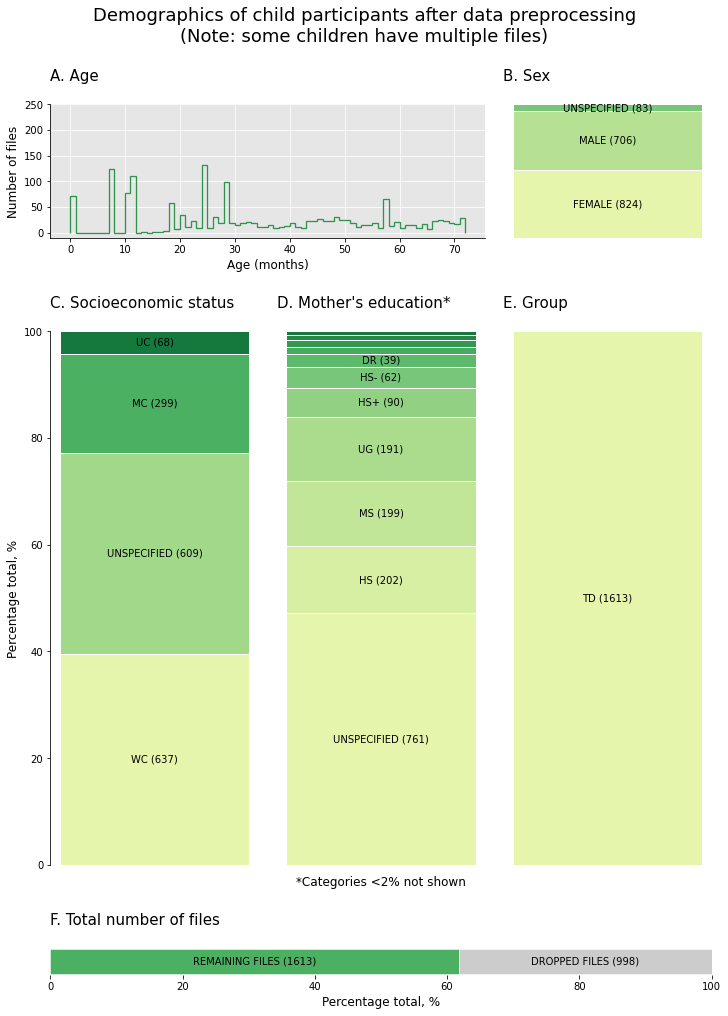

In [61]:
import matplotlib.pyplot as plt

# Data for plotting
# Count files by 'sex', 'ses', 'mot_edu' or 'group'; count dropped files
sex_count = data_idx.groupby('sex').aggregate('count').file_path
ses_count = data_idx.groupby('ses').aggregate('count').file_path
mot_edu_count = data_idx.groupby('mot_edu').aggregate('count').file_path
group_count = data_idx.groupby('group').aggregate('count').file_path
total_count = pd.Series({'Remaining files':len(data_idx),
                         'Dropped files':len(drop_index)+n_drop_group})

# ==============================================================================
# Create a figure object

# Subplot dimension ratio
gs_kw = dict(width_ratios=[1,1,1], height_ratios=[1,4,0.2])

# Create a figure with 6 axes (i.e. 6 subplots), namely A, B, C, D, E, F
fig, ax = plt.subplot_mosaic([['A', 'A', 'B'],  # A spans across two grids
                              ['C', 'D', 'E'],
                              ['F', 'F', 'F']], # F spans across three grids                            
                              gridspec_kw=gs_kw, figsize=(10,14),
                              constrained_layout=True)
cmap = plt.cm.YlGn  # color map
accent_color = cmap(0.7)

# ==============================================================================
# Plotting

# ------------------------------------------------------------------------------
# Plot A
ax['A'].hist(data_idx.age_m, 72, histtype='step', color=accent_color, lw=1.3)

# ------------------------------------------------------------------------------
# Plot B to E

def plot_stack(ax_idx, data, colors, thres=0):
    data = data.sort_values(ascending=False)  # sort by count
    data_pc = data/sum(data)*100  # get percentage from count
    curr_sum = 0  # percentage sum (required for stacking bars)
    for i, pc in enumerate(data_pc):
        ax[ax_idx].bar('x', pc, label=data_pc.index[i], bottom=curr_sum,
                       color=colors[i], edgecolor='w', linewidth=1)
        curr_sum = curr_sum + pc  # for stacking bars  
        # make label
        if data.index[i] == '':
            label = "Unspecified ({})".format(data[i]).upper()
        elif pc >= thres:
            label = "{} ({})".format(data.index[i], data[i]).upper()
        else: label = ''
        label_ypos = curr_sum - (pc/2)
        ax[ax_idx].text(0, label_ypos, label, ha="center", va="center")

for k, v in {'B':sex_count, 'C':ses_count, 
             'D':mot_edu_count, 'E':group_count}.items():
    if k == 'B':
        thres = 0
        colors = cmap(np.linspace(0.2, 0.5, len(v)))
    else:
        thres = 2
        colors = cmap(np.linspace(0.2, 0.8, len(v)))            
    plot_stack(k, v, colors, thres)

# ------------------------------------------------------------------------------
# Plot F
total_count = total_count.sort_values(ascending=False)  # sort by count
total_pc = total_count/sum(total_count)*100  # get percentage from count
colors = [plt.cm.YlGn(0.6), '0.8']
curr_sum = 0  # percentage sum (required for stacking bars)
for i, pc in enumerate(total_pc):
    ax['F'].barh('x', pc, label=total_pc.index[i], left=curr_sum,
                 color=colors[i], edgecolor='w', linewidth=0.5)
    curr_sum = curr_sum + pc    
    # make label
    label = "{} ({})".format(total_count.index[i], total_count[i]).upper()  
    label_xpos = curr_sum - (pc/2)
    ax['F'].text(label_xpos, 0, label, ha="center", va="center", c='k')    

# ------------------------------------------------------------------------------
# Formatting

# Subplot A settings
ax['A'].set_xlabel('Age (months)', size=12)
ax['A'].set_ylabel('Number of files', size=12)
ax['A'].set_ylim([-10,250])
ax['A'].spines[['top', 'right']].set_visible(False)
ax['A'].grid(axis='both', color='w')
ax['A'].set_facecolor('0.9')

# Subplots B-E settings
for i in ['B','C','D','E']:
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylabel('Percentage total, %', size=12)
    ax[i].set_ylim([0,100])
    ax[i].spines[['top','bottom', 'right']].set_visible(False)
    if i in ['B','D','E']:
        ax[i].get_yaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        ax[i].spines['left'].set_visible(False)        
ax['D'].text(0,-2,'*Categories <2% not shown', ha="center", va="top", size=12)

# Subplot F settings
ax['F'].get_yaxis().set_visible(False)
ax['F'].set_xlabel('Percentage total, %', size=12)
ax['F'].set_xlim([0,100])
ax['F'].spines[:].set_visible(False)

# Set subplot titles
ax['A'].set_title('\nA. Age\n', loc='left', size=15)
ax['B'].set_title('\nB. Sex\n', loc='left', size=15)
ax['C'].set_title('\nC. Socioeconomic status\n', loc='left', size=15)
ax['D'].set_title('\nD. Mother\'s education*\n', loc='left', size=15)
ax['E'].set_title('\nE. Group\n', loc = 'left', size=15)
ax['F'].set_title('\nF. Total number of files\n', loc='left', size=15)

# Set figure title
fig.suptitle('Demographics of child participants after data preprocessing\n(Note: some children have multiple files)', fontsize=18)

# Save figure
# plt.savefig('../reports/images/child_demgph_processed.svg', bbox_inches='tight', dpi=150)
plt.show()

# 7. Save the cleaned index table

You may use the index table, `data_idx`, for retrieving data in your dataset. Save the table for data analysis later.

In [62]:
# Save cleaned 'data_idx' as 'data/data_idx_cleaned.pkl'
with open('data/data_idx_cleaned.pkl', 'wb') as f:
    pickle.dump(data_idx, f, -1)    
print("Cleaned 'data_idx' was saved as 'data/data_idx_cleaned.pkl'. ")

Cleaned 'data_idx' was saved as 'data/data_idx_cleaned.pkl'. 


In [ ]:
# Uncomment the following lines to read data into readers and export as pickle

# corpus_readers = [pylangacq.Reader.from_dir(d) for d in tqdm(paths['local_path'])]
# with open('data/corpus_readers.pkl', 'wb') as f:
#     pickle.dump(corpus_readers, f, -1)    
# print("'corpus_readers' was saved as 'data/corpus_readers.pkl'. ")